Transformers vs. LSTM for Stock Price Time Series Prediction 
https://medium.com/@mskmay66/transformers-vs-lstm-for-stock-price-time-series-prediction-3a26fcc1a782

Prediction of Stock Price Time Series using Transformers Lorenzo D. Costa1, Alexei M. C. Machado August 2023
https://www.researchgate.net/publication/372947061_Prediction_of_Stock_Price_Time_Series_using_Transformers

Stock Price Forecast: Comparison of LSTM, HMM, and Transformer Qianzhun Wang1(B) and Yingqing Yuan2
https://www.researchgate.net/publication/372632831_Stock_Price_Forecast_Comparison_of_LSTM_HMM_and_Transformer

Test another transformers model

testing againt

In [11]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from keras import layers
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import time
import timeit
from datetime import datetime

In [12]:


class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """

    def __init__(self, datainput, test_size=0.2, n_input=5, timestep=5, normalize_bool=False, scaler=None) -> None:
        self.datainput = datainput
        self.test_size = test_size
        self.n_input = n_input
        self.timestep = timestep
        self.normalize_bool = normalize_bool
        self.scaler = scaler
        self.df = self.extract_historic_data()
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)

        if self.normalize_bool:
            print('normalized', normalize_bool)
            self.scaler = scaler
        else:
            print('not normalized', normalize_bool)
            self.scaler = None

    def extract_historic_data(self) -> pd.Series:
        """
        Extracts historic data and optionally normalizes it.
        """
        # data = self.datainput
        if self.normalize_bool:
            data = self.scaler.fit_transform(
                self.datainput.values.reshape(-1, 1))
        else:
            data = self.datainput
        return data

    def split_data(self) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        # data = self.extract_historic_data()
        data = self.df
        if len(data) != 0:
            train_idx = round(len(data) * (1-self.test_size))
            train = data[:train_idx]
            test = data[train_idx:]
            train = np.array(train)
            test = np.array(test)
            return train[:, np.newaxis], test[:, np.newaxis]
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs,
        namely, [# samples, timestep, # feautures]
        samples
        """
        NUM_FEATURES = 1
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        output = result.reshape((samples, self.timestep, NUM_FEATURES))
        print(output.shape)
        return output

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        # print("train:", train, "test:", test)
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data()
        return self.transform(train, test)

    def to_supervised(self, train, n_out=5) -> tuple:
        """
        Converts our time series prediction problem to a
        supervised learning problem.
        """
        # flatted the data
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
        X, y = [], []
        in_start = 0
        # step over the entire history one time step at a time
        for _ in range(len(data)):
            # define the end of the input sequence
            in_end = in_start + self.n_input
            out_end = in_end + n_out
            # ensure we have enough data for this instance
            if out_end <= len(data):
                x_input = data[in_start:in_end, 0]
                x_input = x_input.reshape((len(x_input), 1))
                X.append(x_input)
                y.append(data[in_end:out_end, 0])
                # move along one time step
                in_start += 1
        print(np.array(X), np.array(y))
        return np.array(X), np.array(y)

# *******************************
# Implementing a Transformer


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2, epsilon=1e-6, attention_axes=None, kernel_size=1):
    """
    Creates a single transformer block.
    """
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout,
        attention_axes=attention_axes
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size,
                      activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
    return x + res


def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0.2, mlp_dropout=0.2, attention_axes=None, epsilon=1e-6, kernel_size=1):
    """
    Creates final model by building many transformer blocks.
    """
    n_timesteps, n_features, n_outputs = 5, 1, 5
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    x = inputs
    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim,
                                dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(n_outputs)(x)
    return tf.keras.Model(inputs, outputs)


def fit_transformer(transformer: tf.keras.Model, x_train, y_train, X_val, y_val, display_loss=False):
    """
    Compiles and fits our transformer.
    """
    transformer.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["mae", 'mape'])

    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='loss', patience=10, restore_best_weights=True)]
    start = time.time()
    # hist = transformer.fit(data.X_train, data.y_train, batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
    hist = transformer.fit(x_train, y_train, validation_data=(
        X_val, y_val), batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
    print("time used", time.time() - start)
    history_df = pd.DataFrame(hist.history)

    if display_loss:
        history_df['loss'].plot()
        plt.title('Training Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train'], loc='upper right')
        plt.show()
        history_df['val_loss'].plot()
        plt.title('Validation Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Validation'], loc='upper right')
        plt.show()

        # Display minimum validation loss
        min_val_loss = history_df['val_loss'].min()
        print("Minimum validation loss: {:.4f}".format(min_val_loss))
        # Plot mae
        history_df.loc[:, ['mae', 'val_mae']].plot()
        plt.title('Model MAE')
        plt.ylabel('MAE')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()
        # Display minimum validation mae and mape
        min_val_mae = history_df['val_mae'].min()
        min_val_mape = history_df['val_mape'].min()
        print("Minimum validation MAE: {:.4f}".format(min_val_mae))
        print("Minimum validation MAPE: {:.4f}".format(min_val_mape))

    return hist

# **********************


class PredictAndForecast:
    """
    model: tf.keras.Model
    train: np.array
    test: np.array
    Takes a trained model, train, and test datasets and returns predictions
    of len(test) with same shape.
    """

    def __init__(self, model, train, test, n_input=5, scaler=None, normalize_bool=False) -> None:
        self.model = model
        self.train = train
        self.test = test
        self.n_input = n_input
        self.scaler = scaler
        self.normalize_bool = normalize_bool
        self.predictions = self.get_predictions()

    def forecast(self, history) -> np.array:
        """
        Given last weeks actual data, forecasts next weeks prices.
        """
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        # retrieve last observations for input data
        input_x = data[-self.n_input:, :]
        # reshape into [1, n_input, 1]
        input_x = input_x.reshape((1, len(input_x), input_x.shape[1]))
        # forecast the next week
        yhat = self.model.predict(input_x, verbose=0)
        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def get_predictions(self) -> np.array:
        """
        compiles models predictions week by week over entire
        test set.
        """
        # history is a list of weekly data
        history = [x for x in self.train]
        # walk-forward validation over each week
        predictions = []
        for i in range(len(self.test)):
            yhat_sequence = self.forecast(history)
            # store the predictions
            predictions.append(yhat_sequence)
            # get real observation and add to history for predicting the next week
            history.append(self.test[i, :])
        predictions = np.array(predictions)
        # if self.normalize_bool:
        # Inverse transform to get back to original scale
        #    predictions = self.scaler.inverse_transform(
        #        predictions.reshape(-1, 1)).reshape(predictions.shape)
        return predictions


class Evaluate:

    def __init__(self, actual, predictions, normalize_bool=False, scaler=None) -> None:
        if normalize_bool:
            actual = scaler.inverse_transform(
                actual.reshape(-1, 1)).reshape(actual.shape)
            predictions = scaler.inverse_transform(
                predictions.reshape(-1, 1)).reshape(predictions.shape)
        self.actual = actual
        self.predictions = predictions
        self.var_ratio = self.compare_var()
        self.mape = self.evaluate_model_with_mape()
        self.rmse = self.evaluate_model_with_rmse()
        self.mae = self.evaluate_model_with_mae()
        self.r2 = self.evaluate_model_with_r2()

    def compare_var(self):
        return abs(1 - (np.var(self.predictions) / np.var(self.actual)))

    def evaluate_model_with_mape(self):
        return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

    def evaluate_model_with_rmse(self):
        return root_mean_squared_error(self.actual.flatten(), self.predictions.flatten())

    def evaluate_model_with_mae(self):
        return mean_absolute_error(self.actual.flatten(), self.predictions.flatten())

    def evaluate_model_with_r2(self):
        return r2_score(self.actual.flatten(), self.predictions.flatten())


def plot_results(train, test, preds, df, normalize_bool=False, scaler=None, title_suffix=None, xlabel='AAPL stock Price'):
    """
    Plots training data in blue, actual values in red, and predictions in green,
    over time.
    """

    fig, ax = plt.subplots(figsize=(20, 6))
    # x = df.Close[-498:].index
    plot_test = test[1:]
    plot_preds = preds[1:]
    if normalize_bool:
        # Inverse transform to get back to original scale
        plot_test = scaler.inverse_transform(
            plot_test.reshape(-1, 1)).reshape(plot_test.shape)
        train = scaler.inverse_transform(
            train.reshape(-1, 1)).reshape(train.shape)
        plot_preds = scaler.inverse_transform(
            plot_preds.reshape(-1, 1)).reshape(plot_preds.shape)
        print("normalization convert active")

    # x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
    plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    plot_train = train.reshape((train.shape[0]*train.shape[1], 1))
    print(f'plot_train shape: {plot_train.shape}')
    print(f'plot_test shape: {plot_test.shape}')
    print(f'plot_preds shape: {plot_preds.shape}')

    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)

    x_train = df[:len(plot_train)].index
    x_test = df[len(plot_train):len(plot_train) + len(plot_test)].index

    ax.plot(x_train, plot_train, label='Train', color='blue')
    ax.plot(x_test, plot_test, label='actual', color='red')
    ax.plot(x_test, plot_preds, label='preds', color='green')
    if title_suffix == None:
        ax.set_title('Predictions vs. Actual')
    else:
        ax.set_title(f'Predictions vs. Actual, {title_suffix}')
    ax.set_xlabel('Date')
    ax.set_ylabel(xlabel)
    ax.legend()
    plt.show()

[*********************100%%**********************]  1 of 1 completed

(1393, 5, 1)
(348, 5, 1)
[[[ 0.332589  ]
  [ 0.33482099]
  [ 0.33593801]
  [ 0.33705401]
  [ 0.339286  ]]

 [[ 0.33482099]
  [ 0.33593801]
  [ 0.33705401]
  [ 0.339286  ]
  [ 0.33593801]]

 [[ 0.33593801]
  [ 0.33705401]
  [ 0.339286  ]
  [ 0.33593801]
  [ 0.32142901]]

 ...

 [[39.09749985]
  [39.70249939]
  [40.02000046]
  [40.26499939]
  [38.83000183]]

 [[39.70249939]
  [40.02000046]
  [40.26499939]
  [38.83000183]
  [39.36999893]]

 [[40.02000046]
  [40.26499939]
  [38.83000183]
  [39.36999893]
  [39.96250153]]] [[ 0.33593801  0.32142901  0.308036    0.308036    0.30580401]
 [ 0.32142901  0.308036    0.308036    0.30580401  0.31138399]
 [ 0.308036    0.308036    0.30580401  0.31138399  0.296875  ]
 ...
 [39.36999893 39.96250153 40.40000153 40.23749924 39.46500015]
 [39.96250153 40.40000153 40.23749924 39.46500015 39.375     ]
 [40.40000153 40.23749924 39.46500015 39.375      39.30250168]]
[[[ 39.99499893]
  [ 39.81750107]
  [ 39.96500015]
  [ 40.36750031]
  [ 40.72750092]]

 [[ 39

218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 24.5212 - mae: 2.0973 - mape: 111.9516 - val_loss: 28.3607 - val_mae: 3.6476 - val_mape: 3.2509
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9669 - mae: 0.4565 - mape: 10.0178 - val_loss: 34.9348 - val_mae: 4.4970 - val_mape: 4.0214
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7841 - mae: 0.4180 - mape: 11.8368 - val_loss: 23.7791 - val_mae: 3.4439 - val_mape: 3.0685
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.6309 - mae: 0.3781 - mape: 10.1995 - val_loss: 19.1556 - val_mae: 3.0900 - val_mape: 2.7512
Epoch 5/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5786 - mae: 0.3644 - mape: 10.3619 - val_loss: 19.7259 - val_mae: 3.1302 - val_mape: 2.7891
Epoch 6/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5265 - mae: 0.3501 - mape: 9.9829 - val_loss: 21.0229 - val_mae: 3.2063 - val_mape: 2.8580
Epoch 7/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.4605 - mae: 0.3240 - map

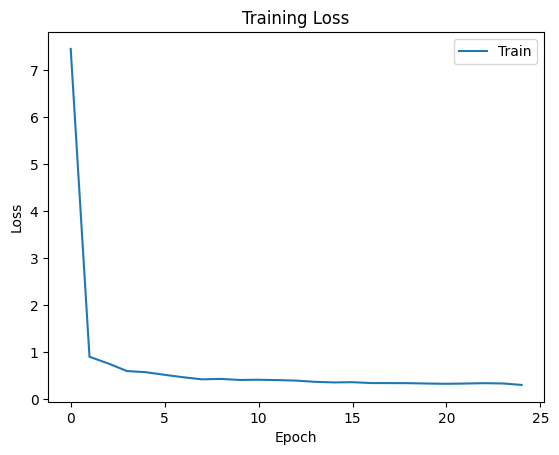

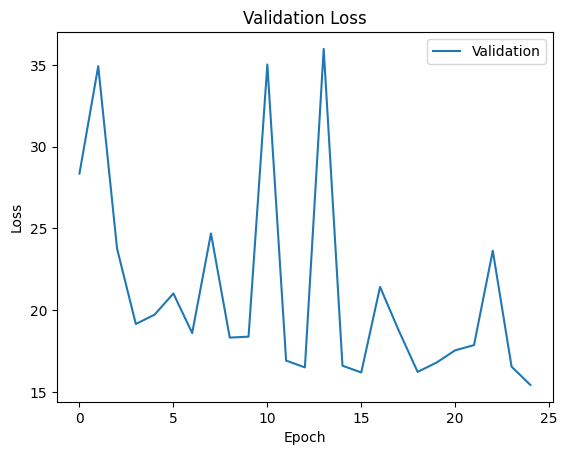

Minimum validation loss: 15.4262


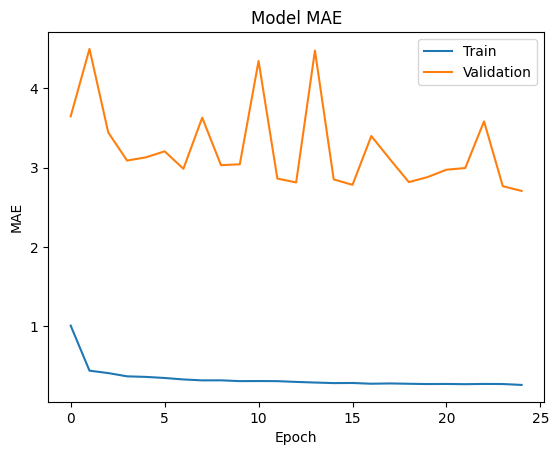

Minimum validation MAE: 2.7072
Minimum validation MAPE: 2.4078
plot_train shape: (6965, 1)
plot_test shape: (1735, 1)
plot_preds shape: (1735, 1)


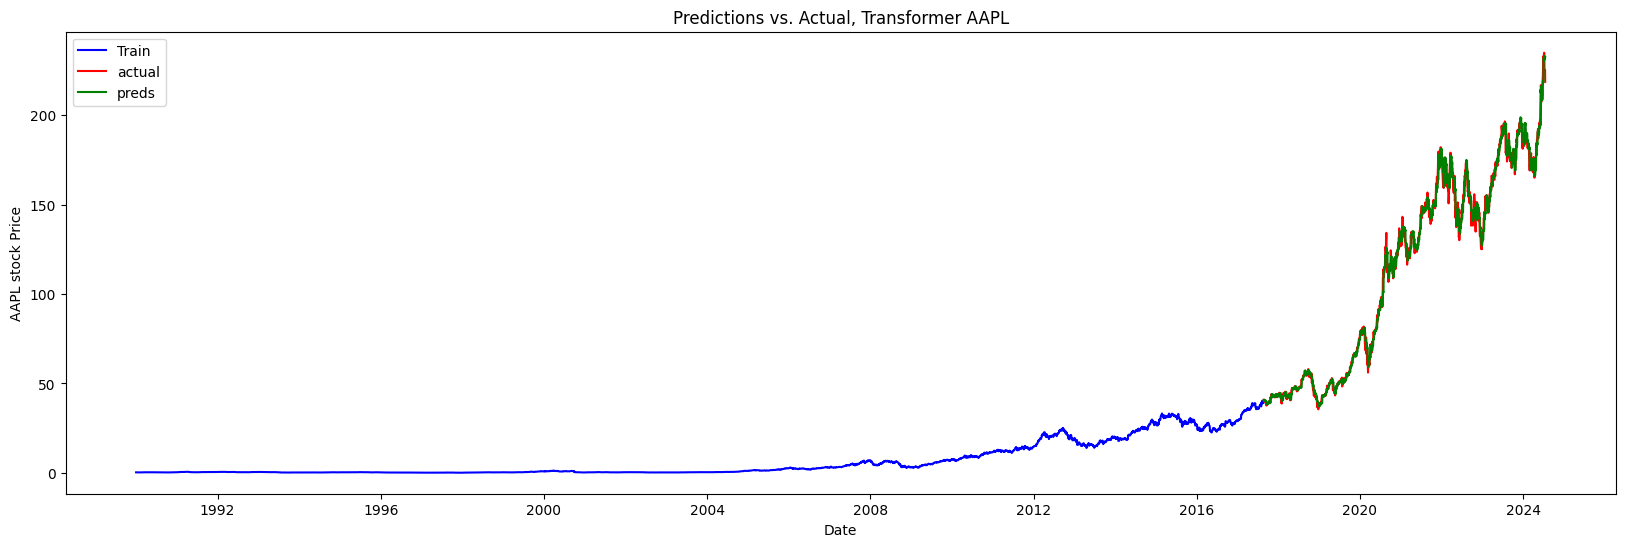

MAPE: 0.023529539177126337
RMSE: 3.8588773188808743
MAE: 2.6648834688910124
R-squared: 0.9950842316158253


In [19]:
# ticker = 'NDX'
ticker = 'AAPL'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]

normaliza_bool_update = False
type_normalisation_update = None

data = ETL(datainput=dataset, test_size=0.2, n_input=5, timestep=5,
           normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)

transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[
                                256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
# transformer.summary()
# train the model
# hist = fit_transformer(transformer)
hist = fit_transformer(transformer, data.X_train,
                       data.y_train, data.X_test, data.y_test, display_loss=True)
# time used

transformer_preds = PredictAndForecast(transformer, data.train, data.test, n_input=5,
                                       scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

plot_results(data.train, data.test, transformer_preds.predictions,
             data.df, title_suffix='Transformer AAPL')
train_evaluation = Evaluate(data.test, transformer_preds.predictions)
print(f"MAPE: {train_evaluation.mape}")
print(f"RMSE: {train_evaluation.rmse}")
print(f"MAE: {train_evaluation.mae}")
print(f"R-squared: {train_evaluation.r2}")

[*********************100%%**********************]  1 of 1 completed

(170, 5, 1)
(42, 5, 1)
[[[ 9629.79980469]
  [ 9718.73046875]
  [ 9627.83007812]
  [ 9446.69042969]
  [ 9079.62988281]]

 [[ 9718.73046875]
  [ 9627.83007812]
  [ 9446.69042969]
  [ 9079.62988281]
  [ 8834.87011719]]

 [[ 9627.83007812]
  [ 9446.69042969]
  [ 9079.62988281]
  [ 8834.87011719]
  [ 8873.75976562]]

 ...

 [[15037.65039062]
  [14876.46972656]
  [14715.80957031]
  [14694.83984375]
  [14936.69042969]]

 [[14876.46972656]
  [14715.80957031]
  [14694.83984375]
  [14936.69042969]
  [14908.95996094]]

 [[14715.80957031]
  [14694.83984375]
  [14936.69042969]
  [14908.95996094]
  [15148.05957031]]] [[ 8834.87011719  8873.75976562  8436.66992188  8461.83007812
   8877.98046875]
 [ 8873.75976562  8436.66992188  8461.83007812  8877.98046875
   8594.49023438]
 [ 8436.66992188  8461.83007812  8877.98046875  8594.49023438
   8949.28027344]
 ...
 [14908.95996094 15148.05957031 14816.44042969 14941.83007812
  15052.45996094]
 [15148.05957031 14816.44042969 14941.83007812 15052.45996094
  

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 119921000.0000 - mae: 10124.2842 - mape: 78.5153 - val_loss: 3396953.2500 - val_mae: 1622.6635 - val_mape: 9.3817
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2636466.2500 - mae: 1311.6376 - mape: 10.1695 - val_loss: 687344.1875 - val_mae: 708.4142 - val_mape: 4.1336
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1435336.8750 - mae: 950.3843 - mape: 7.5080 - val_loss: 240622.6875 - val_mae: 405.9655 - val_mape: 2.3573
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1320117.0000 - mae: 917.1965 - mape: 7.1859 - val_loss: 152090.1719 - val_mae: 317.7285 - val_mape: 1.8634
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1240691.0000 - mae: 882.7366 - mape: 6.8808 - val_loss: 176123.8594 - val_mae: 345.0407 - val_mape: 2.0128
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1266492.5000 - mae: 876.6585 - mape: 6.9420 - val_loss: 141519.5156 - val_mae: 303.5144 - val_mape: 1.7851
Epoch 7/25


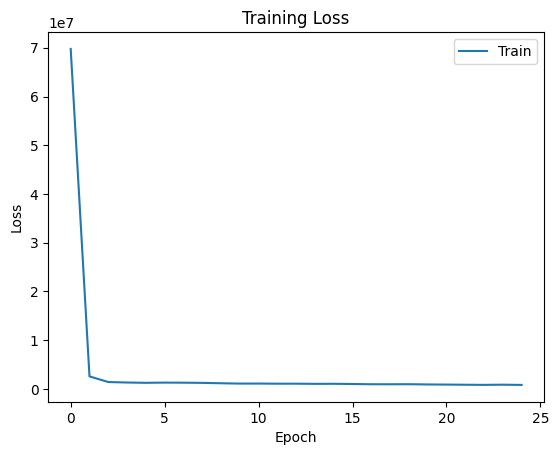

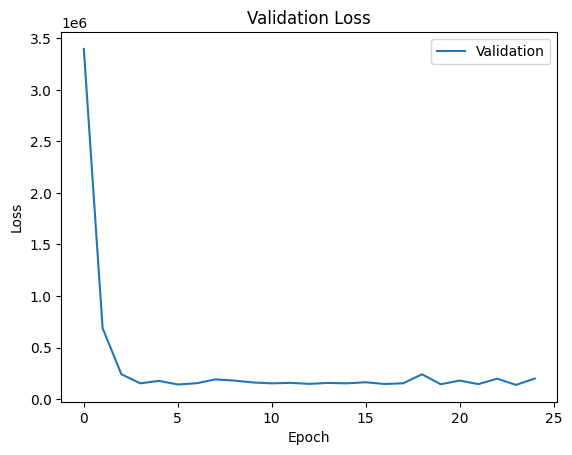

Minimum validation loss: 136972.5156


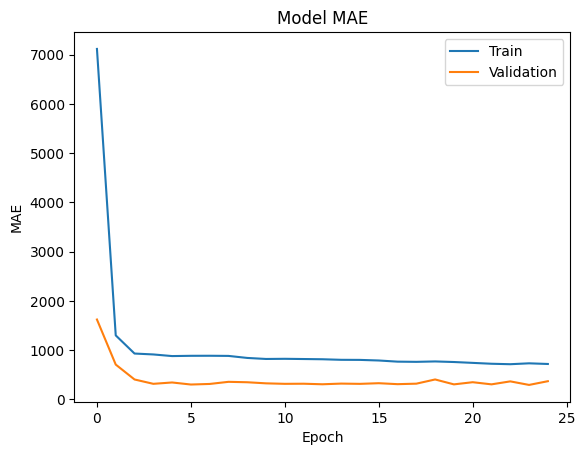

Minimum validation MAE: 295.4360
Minimum validation MAPE: 1.7415
plot_train shape: (850, 1)
plot_test shape: (205, 1)
plot_preds shape: (205, 1)


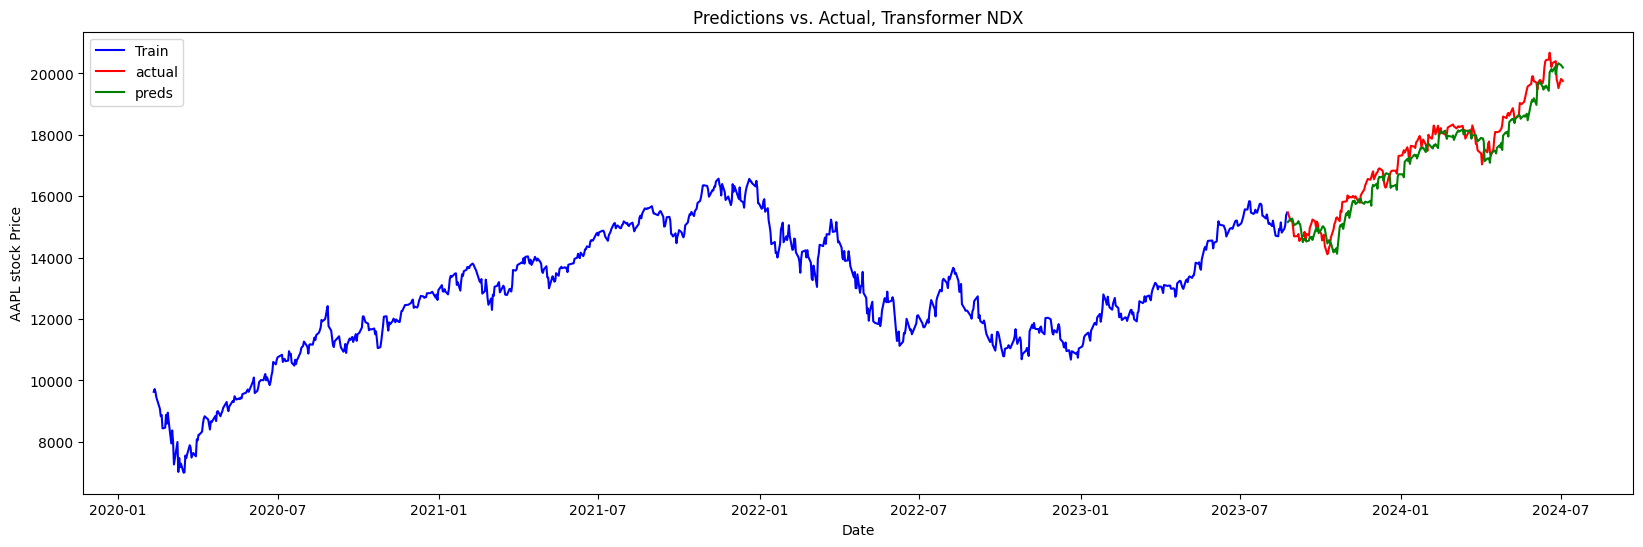

MAPE: 0.021738372835842165
RMSE: 448.8572010776705
MAE: 373.58724423363094
R-squared: 0.9268566046883061


In [16]:
ticker = 'NDX'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]

normaliza_bool_update = False
type_normalisation_update = None

data = ETL(datainput=dataset, test_size=0.2, n_input=5, timestep=5,
           normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)

transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[
                                256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
# transformer.summary()
# train the model
# hist = fit_transformer(transformer)
hist = fit_transformer(transformer, data.X_train,
                       data.y_train, data.X_test, data.y_test, display_loss=True)
# time used

transformer_preds = PredictAndForecast(transformer, data.train, data.test, n_input=5,
                                       scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

plot_results(data.train, data.test, transformer_preds.predictions,
             data.df, title_suffix='Transformer NDX')
train_evaluation = Evaluate(data.test, transformer_preds.predictions)
print(f"MAPE: {train_evaluation.mape}")
print(f"RMSE: {train_evaluation.rmse}")
print(f"MAE: {train_evaluation.mae}")
print(f"R-squared: {train_evaluation.r2}")

Move average data

[*********************100%%**********************]  1 of 1 completed

(1391, 5, 1)
(347, 5, 1)
[[[ 0.3152905 ]
  [ 0.3121655 ]
  [ 0.3079244 ]
  [ 0.3044645 ]
  [ 0.3026787 ]]

 [[ 0.3121655 ]
  [ 0.3079244 ]
  [ 0.3044645 ]
  [ 0.3026787 ]
  [ 0.3023439 ]]

 [[ 0.3079244 ]
  [ 0.3044645 ]
  [ 0.3026787 ]
  [ 0.3023439 ]
  [ 0.3007814 ]]

 ...

 [[38.50725021]
  [38.69724998]
  [38.81625023]
  [39.01575012]
  [39.29375038]]

 [[38.69724998]
  [38.81625023]
  [39.01575012]
  [39.29375038]
  [39.58250046]]

 [[38.81625023]
  [39.01575012]
  [39.29375038]
  [39.58250046]
  [39.6777504 ]]] [[ 0.3023439   0.3007814   0.2998885   0.2991072   0.2997768 ]
 [ 0.3007814   0.2998885   0.2991072   0.2997768   0.3008928 ]
 [ 0.2998885   0.2991072   0.2997768   0.3008928   0.3008928 ]
 ...
 [39.58250046 39.6777504  39.73500023 39.76275024 39.72275047]
 [39.6777504  39.73500023 39.76275024 39.72275047 39.7152504 ]
 [39.73500023 39.76275024 39.72275047 39.7152504  39.68825035]]
[[[ 39.97975044]
  [ 40.13325043]
  [ 40.2970005 ]
  [ 40.41875038]
  [ 40.4720005 ]]

 [[ 40


/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_1095/3526995877.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['SMA'] = dataset.rolling(window=period).mean()


218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 45.3009 - mae: 2.5943 - mape: 63.4602 - val_loss: 15.0259 - val_mae: 2.9319 - val_mape: 2.6617
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9706 - mae: 0.4485 - mape: 11.2665 - val_loss: 13.3776 - val_mae: 2.7128 - val_mape: 2.4493
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7723 - mae: 0.4026 - mape: 10.2169 - val_loss: 10.0404 - val_mae: 2.2787 - val_mape: 2.0418
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.6165 - mae: 0.3668 - mape: 10.4956 - val_loss: 17.0116 - val_mae: 3.2161 - val_mape: 2.8963
Epoch 5/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5164 - mae: 0.3450 - mape: 10.8400 - val_loss: 18.0815 - val_mae: 3.0851 - val_mape: 2.7510
Epoch 6/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.4091 - mae: 0.3078 - mape: 9.8530 - val_loss: 15.1701 - val_mae: 2.6735 - val_mape: 2.3852
Epoch 7/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3970 - mae: 0.3000 - mape

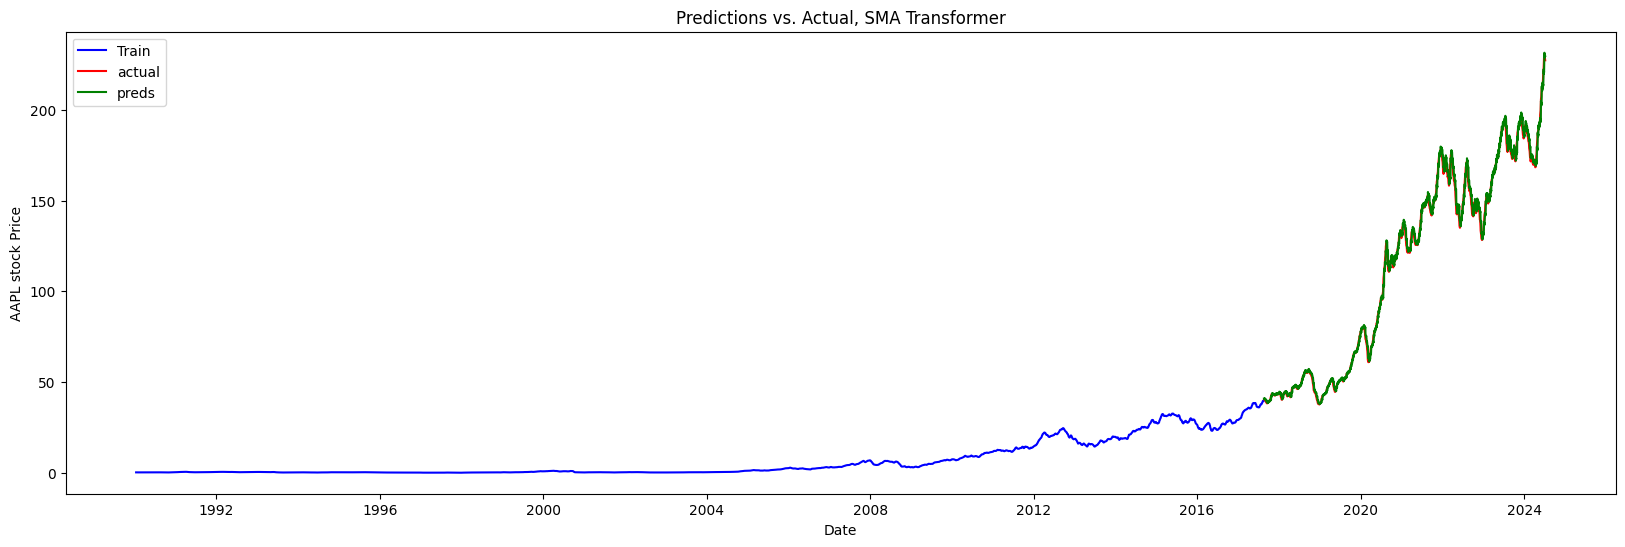

MAPE: 0.016695208376103922
RMSE: 2.6048942474406322
MAE: 1.8626346651896273
R-squared: 0.9977352951778797


In [9]:

period = 20  # 20 days moving average

ticker = 'AAPL'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]
dataset['SMA'] = dataset.rolling(window=period).mean()

normaliza_bool_update = False
type_normalisation_update = None

data_norm = ETL(datainput=dataset['SMA'].dropna(), test_size=0.2, n_input=5, timestep=5,
                normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)

transformer_norm = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4,
                                     mlp_units=[256],
                                     mlp_dropout=0.1, dropout=0.1, attention_axes=1)

# train the model
hist = fit_transformer(transformer_norm, data_norm.X_train,
                       data_norm.y_train, data_norm.X_test, data_norm.y_test, display_loss=False)
# time used
transformer_preds_norm = PredictAndForecast(transformer, data_norm.train, data_norm.test, n_input=5,
                                            scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

plot_results(data_norm.train, data_norm.test, transformer_preds_norm.predictions,
             data_norm.df, normaliza_bool_update, type_normalisation_update, title_suffix='SMA Transformer')

train_evaluation = Evaluate(data_norm.test, transformer_preds_norm.predictions)
print(f"MAPE: {train_evaluation.mape}")
print(f"RMSE: {train_evaluation.rmse}")
print(f"MAE: {train_evaluation.mae}")
print(f"R-squared: {train_evaluation.r2}")

including Normalization Maxmin

[*********************100%%**********************]  1 of 1 completed

(1393, 5, 1)
(348, 5, 1)
[[[0.00092489]
  [0.0009344 ]
  [0.00093916]
  [0.00094391]
  [0.00095342]]

 [[0.0009344 ]
  [0.00093916]
  [0.00094391]
  [0.00095342]
  [0.00093916]]

 [[0.00093916]
  [0.00094391]
  [0.00095342]
  [0.00093916]
  [0.00087734]]

 ...

 [[0.16608965]
  [0.16866736]
  [0.17002012]
  [0.17106399]
  [0.16494993]]

 [[0.16866736]
  [0.17002012]
  [0.17106399]
  [0.16494993]
  [0.16725068]]

 [[0.17002012]
  [0.17106399]
  [0.16494993]
  [0.16725068]
  [0.16977514]]] [[0.00093916 0.00087734 0.00082028 0.00082028 0.00081077]
 [0.00087734 0.00082028 0.00082028 0.00081077 0.00083454]
 [0.00082028 0.00082028 0.00081077 0.00083454 0.00077272]
 ...
 [0.16725068 0.16977514 0.17163919 0.17094682 0.16765545]
 [0.16977514 0.17163919 0.17094682 0.16765545 0.16727199]
 [0.17163919 0.17094682 0.16765545 0.16727199 0.16696309]]
[[[0.1699136 ]
  [0.16915734]
  [0.16978579]
  [0.17150071]
  [0.17303456]]

 [[0.16915734]
  [0.16978579]
  [0.17150071]
  [0.17303456]
  [0.17350323]]


218/218 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 5.5816e-04 - mae: 0.0122 - mape: 1821.3654 - val_loss: 0.0064 - val_mae: 0.0594 - val_mape: 10.3076
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.7593e-05 - mae: 0.0027 - mape: 343.4006 - val_loss: 0.0039 - val_mae: 0.0453 - val_mape: 8.1514
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.9572e-05 - mae: 0.0030 - mape: 327.6246 - val_loss: 0.0033 - val_mae: 0.0408 - val_mape: 7.1676
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.2761e-05 - mae: 0.0023 - mape: 266.5524 - val_loss: 0.0025 - val_mae: 0.0358 - val_mape: 6.2259
Epoch 5/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.3490e-05 - mae: 0.0024 - mape: 762.2844 - val_loss: 0.0022 - val_mae: 0.0333 - val_mape: 5.9412
Epoch 6/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0987e-05 - mae: 0.0020 - mape: 302.1264 - val_loss: 0.0023 - val_mae: 0.0338 - val_mape: 5.9140
Epoch 7/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1

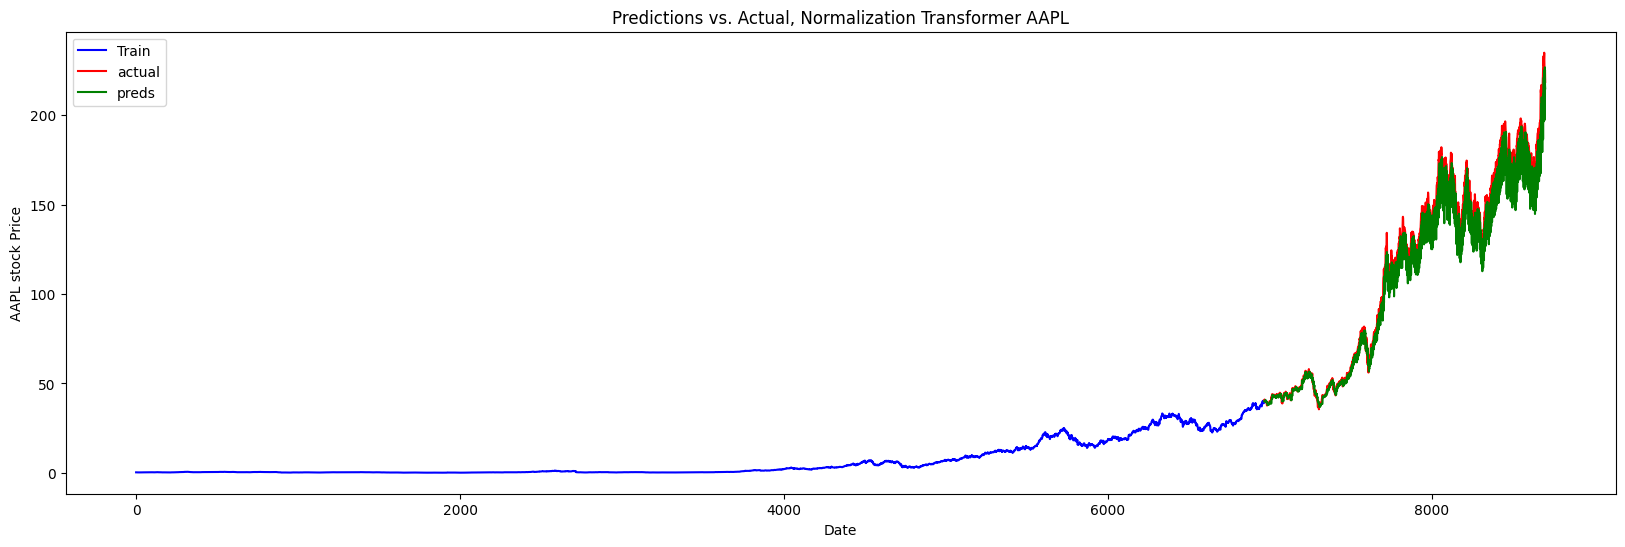

MAPE: 0.05004726679243149
RMSE: 9.729454007194878
MAE: 6.607096237971865
R-squared: 0.9687502600630449


In [20]:
# ticker = 'NDX'
ticker = 'AAPL'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]

normaliza_bool_update = True
type_normalisation_update = MinMaxScaler()

data1 = ETL(datainput=dataset, test_size=0.2, n_input=5, timestep=5,
            normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)

transformer1 = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[
    256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
# transformer1.summary()
# train the model
hist1 = fit_transformer(transformer1, data1.X_train,
                        data1.y_train, data1.X_test, data1.y_test, display_loss=False)

transformer_preds_1 = PredictAndForecast(transformer1, data1.train, data1.test, n_input=5,
                                         scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

plot_results(data1.train, data1.test, transformer_preds_1.predictions,
             data1.df, normaliza_bool_update, type_normalisation_update, title_suffix='Normalization Transformer AAPL')
train_evaluation = Evaluate(data1.test, transformer_preds_1.predictions,
                            normaliza_bool_update, type_normalisation_update)
print(f"MAPE: {train_evaluation.mape}")
print(f"RMSE: {train_evaluation.rmse}")
print(f"MAE: {train_evaluation.mae}")
print(f"R-squared: {train_evaluation.r2}")

[*********************100%%**********************]  1 of 1 completed

(170, 5, 1)
(42, 5, 1)
[[[0.19263886]
  [0.19913912]
  [0.19249489]
  [0.17925474]
  [0.15242497]]

 [[0.19913912]
  [0.19249489]
  [0.17925474]
  [0.15242497]
  [0.1345346 ]]

 [[0.19249489]
  [0.17925474]
  [0.15242497]
  [0.1345346 ]
  [0.13737718]]

 ...

 [[0.58791806]
  [0.57613679]
  [0.56439356]
  [0.56286081]
  [0.58053853]]

 [[0.57613679]
  [0.56439356]
  [0.56286081]
  [0.58053853]
  [0.57851161]]

 [[0.56439356]
  [0.56286081]
  [0.58053853]
  [0.57851161]
  [0.59598826]]] [[0.1345346  0.13737718 0.10542872 0.10726777 0.13768569]
 [0.13737718 0.10542872 0.10726777 0.13768569 0.11696437]
 [0.10542872 0.10726777 0.13768569 0.11696437 0.14289725]
 ...
 [0.57851161 0.59598826 0.57174903 0.58091421 0.58900054]
 [0.59598826 0.57174903 0.58091421 0.58900054 0.61268943]
 [0.57174903 0.58091421 0.58900054 0.61268943 0.6189667 ]]
[[[0.60406218]
  [0.60564911]
  [0.6189258 ]
  [0.60634421]
  [0.61064138]]

 [[0.60564911]
  [0.6189258 ]
  [0.60634421]
  [0.61064138]
  [0.61980435]]

 

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1388 - mae: 0.3216 - mape: 111145.4766 - val_loss: 0.0825 - val_mae: 0.2752 - val_mape: 36.0260
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0130 - mae: 0.0904 - mape: 195829.3594 - val_loss: 0.0350 - val_mae: 0.1770 - val_mape: 22.9225
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - mae: 0.0618 - mape: 177552.1562 - val_loss: 0.0092 - val_mae: 0.0862 - val_mape: 10.9089
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - mae: 0.0470 - mape: 146306.8594 - val_loss: 0.0074 - val_mae: 0.0791 - val_mape: 10.2087
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - mae: 0.0397 - mape: 99691.9766 - val_loss: 0.0027 - val_mae: 0.0462 - val_mape: 6.0143
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020 - mae: 0.0343 - mape: 206168.7969 - val_loss: 8.5625e-04 - val_mae: 0.0240 - val_mape: 3.2319
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mae:

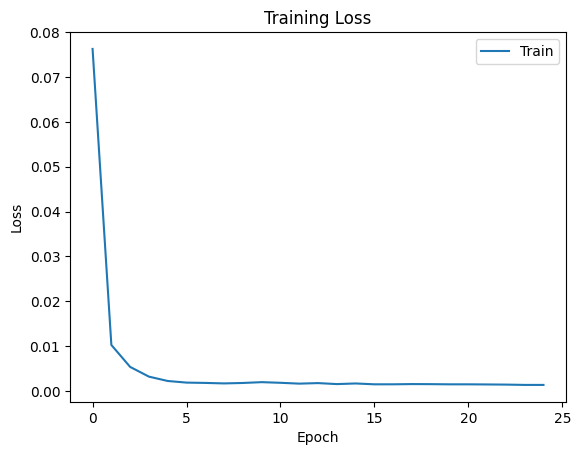

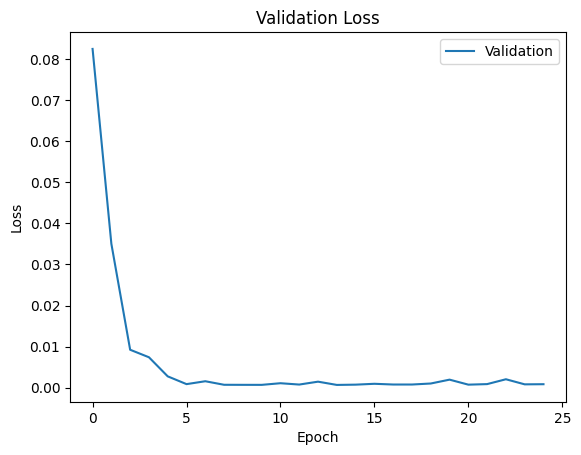

Minimum validation loss: 0.0007


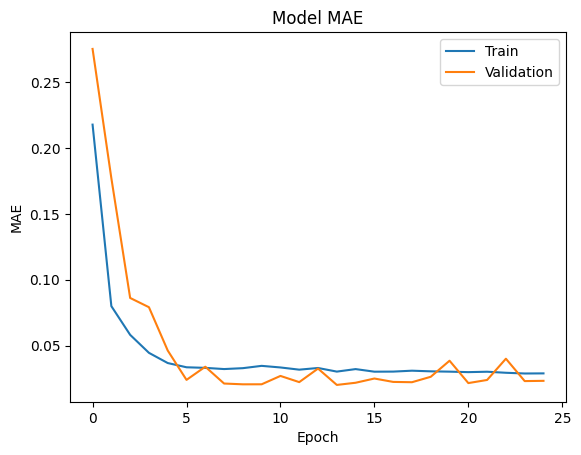

Minimum validation MAE: 0.0201
Minimum validation MAPE: 2.8144
normalization convert active
plot_train shape: (850, 1)
plot_test shape: (205, 1)
plot_preds shape: (205, 1)


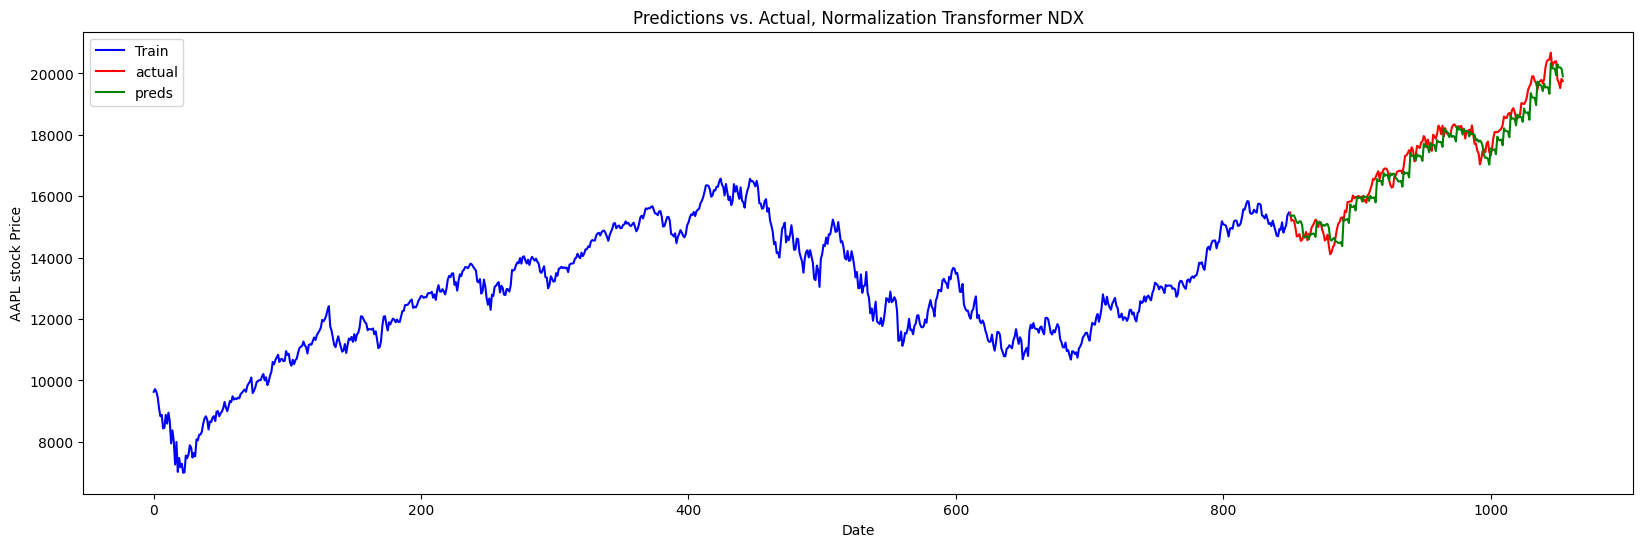

MAPE: 0.018081159647608275
RMSE: 388.0161462927952
MAE: 312.2552641369047
R-squared: 0.9453414233210207


In [17]:
ticker = 'NDX'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]

normaliza_bool_update = True
type_normalisation_update = MinMaxScaler()

data2 = ETL(datainput=dataset, test_size=0.2, n_input=5, timestep=5,
            normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)

transformer2 = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[
    256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
# transformer1.summary()
# train the model
hist1 = fit_transformer(transformer2, data2.X_train,
                        data2.y_train, data2.X_test, data2.y_test, display_loss=True)

transformer_preds_2 = PredictAndForecast(transformer2, data2.train, data2.test, n_input=5,
                                         scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

plot_results(data2.train, data2.test, transformer_preds_2.predictions,
             data2.df, normaliza_bool_update, type_normalisation_update, title_suffix='Normalization Transformer NDX')
train_evaluation = Evaluate(data2.test, transformer_preds_2.predictions,
                            normaliza_bool_update, type_normalisation_update)
print(f"MAPE: {train_evaluation.mape}")
print(f"RMSE: {train_evaluation.rmse}")
print(f"MAE: {train_evaluation.mae}")
print(f"R-squared: {train_evaluation.r2}")

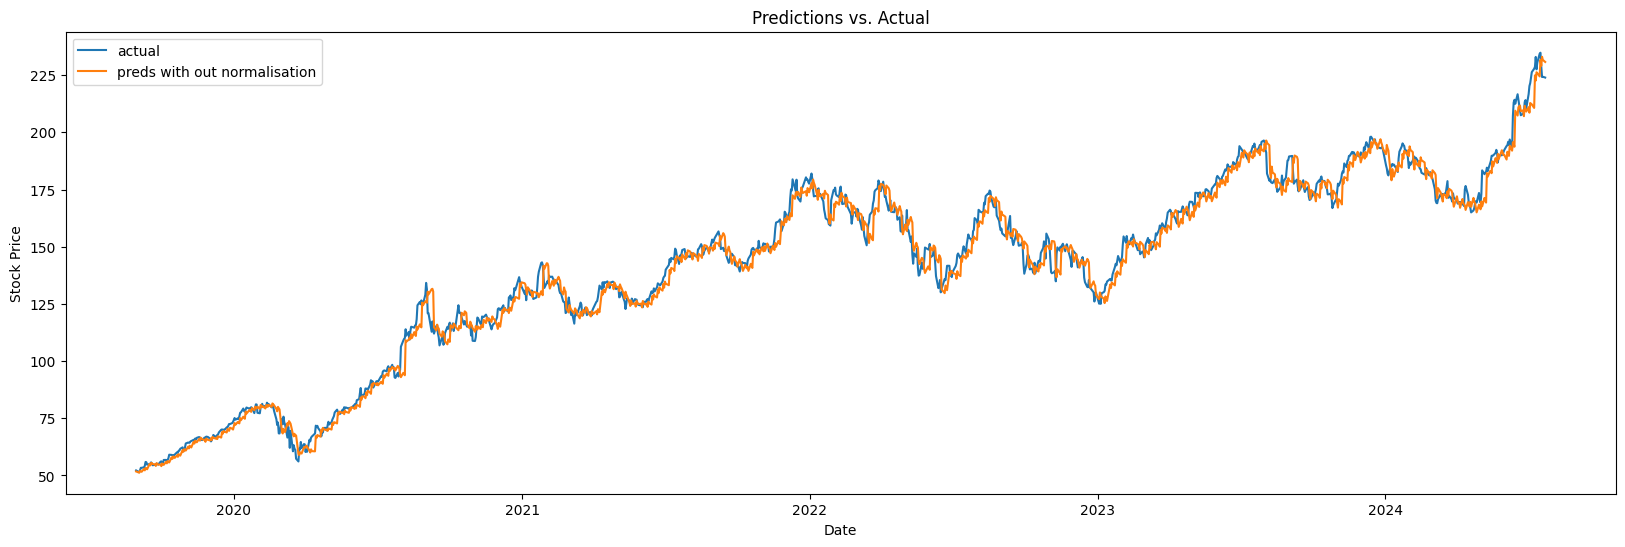

In [ ]:
# plot_results(data.test, transformer_preds.predictions, data.df, title_suffix='Transformer')

fig, ax = plt.subplots(figsize=(20, 6))
# x = df.Close[-498:].index
plot_test = data.test[1:]
plot_preds = transformer_preds.predictions[1:]
x = data.df[-(plot_test.shape[0]*plot_test.shape[1]):].index
plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
ax.plot(x, plot_test, label='actual')
ax.plot(x, plot_preds, label='preds with out normalisation')
ax.set_title(f'Predictions vs. Actual')
ax.set_xlabel('Date')
ax.set_ylabel("Stock Price")
ax.legend()
plt.show()